In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import sin
%matplotlib inline

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.7 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например

### Дополнительная часть  (0.4 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)

In [2]:
def isoptimal(zstar):
    for z in zstar:
        if (z < 0):
            return False
    return True

In [3]:
def getenteringindex(size, zstar, nonbasic):
    index = size + 1
    for i in range(len(zstar)):
        if zstar[i] < 0 and nonbasic[i] < index:
            index = i + 1
    return index

In [4]:
def getleavingindex(size, primalstepdirection, xstar, basic):
    values = primalstepdirection / xstar
    nans = np.isnan(values)
    values[nans] = 0
    value = np.max(values)
    index = size + 1
    for i in range(len(xstar)):
        if values[i] == value and basic[i] < index:
            index = i
    return (1 / values[index]), index + 1

In [5]:
def lexical(primalstepdirection, xstar, N, basic):
    values = primalstepdirection / xstar
    nans = np.isnan(values)
    values[nans] = 0
    value = np.max(values)
    rows = []
    indexes = []
    for i in range(len(xstar)):
        if values[i] == value:
            row = [xstar[i] / basic[i]]
            row += list(N[i] / (-basic[i]))
            rows += [row]
            indexes += [i]
    index = np.argmin(rows, axis=0)[0]
    return (1 / value), indexes[index] + 1

In [6]:
def changebasis(basic, nonbasic,
                enteringindex, leavingindex):
    temp = basic[leavingindex - 1]
    basic[leavingindex - 1] = nonbasic[enteringindex - 1]
    nonbasic[enteringindex - 1] = temp

In [7]:
def changematrix(B, N,
                 enteringindex, leavingindex):
    temp = B[:, leavingindex - 1].copy()
    B[:, leavingindex - 1] = N[:, enteringindex - 1]
    N[:, enteringindex - 1] = temp

In [8]:
def solution(n, m, c, basic, nonbasic, xstar):
    answer = np.zeros(n + m)
    answer[basic - 1] = xstar
    answer[nonbasic - 1] = 0
    return answer[:n], c @ (answer[:n]).T

In [9]:
def getpoint(n, m, xstar, basic, nonbasic):
    values = np.zeros(n + m)
    values[basic - 1] = xstar
    values[nonbasic - 1] = 0
    return list(values[:n])

In [10]:
def ok(A, b, x, y):
    vector = np.array([x, y])
    values = A @ vector.T
    for i in range(len(values)):
        if values[i] > b[i]:
            return False
    return True

In [11]:
def getpoints(a, b):
    y = 0
    x = 0
    other = []
    if a[1] != 0:
        y = b / a[1]
    if a[0] != 0:
        x = b / a[0]
    if x > 0 and y > 0:
        other = [[0, y], [x, 0]]
    elif x > 0 and y < 0:
        other = [[x, 0], [10 * x, (b - a[0] * 10 * x) / a[1]]]
    elif y > 0 and x < 0:
        other = [[0, y], [(b - a[1] * 10 * y) / a[0], 10 * y]]
    elif y == 0 and x > 0:
        other = [[x, 0], [x, 10]]
    elif x == 0 and y > 0:
        other = [[0, y], [10, y]]
    return other

In [12]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0] * p2[1] - p2[0] * p1[1])
    return A, B, -C

In [13]:
def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x, y
    else:
        return 0, 0

In [14]:
def pivot(xstar, zstar, N, basic, nonbasic):
    m = len(basic)
    leavingindex = np.argmin(xstar)
    row = N[leavingindex]
    N = N - row
    N[leavingindex] = -row
    N[:, 0] = -np.ones(m)
    changebasis(basic, nonbasic, 1, leavingindex + 1)
    value = -xstar[leavingindex]
    xstar = xstar + value
    xstar[leavingindex] = value
    zstar = row
    zstar[0] = 1
    return xstar, zstar, N, basic, nonbasic

In [15]:
def auxiliary(A, b):
    n = A.shape[1]
    m = A.shape[0]
    basic = np.arange(n + 1, n + m + 1)
    nonbasic = np.arange(0, n + 1)
    xstar = b.copy()
    zstar = [-1] + [0] * n
    B = np.eye(m)
    N = np.c_[-np.ones(m), A.copy()]
    xstar, zstar, N, basic, nonbasic = pivot(xstar, zstar, N,  basic, nonbasic)
    while True:
        if (isoptimal(zstar)):
            for i in range(n + 1):
                if nonbasic[i] == 0:
                    N = np.delete(N, i, 1)
                    nonbasic = np.delete(nonbasic, i, 0)
                    break
            return basic, nonbasic, N, xstar
        else:
            enteringindex = np.argmin(zstar)
            vector = np.eye(n + 1)[enteringindex]
            primalstepdirection = np.linalg.inv(B) @ N @ vector.T
            values = primalstepdirection / xstar
            leavingindex = np.argmax(values)
            t = 1 / values[leavingindex]
            vector = np.eye(m)[leavingindex]
            dualstepdirection = -(np.linalg.inv(B) @ N).T @ vector.T
            s = zstar[enteringindex] / dualstepdirection[enteringindex]
            xstar = xstar - t * primalstepdirection
            zstar = zstar - s * dualstepdirection
            zstar[enteringindex] = s
            xstar[leavingindex] = t
            changebasis(basic, nonbasic,
                        enteringindex + 1, leavingindex + 1)
            changematrix(B, N, enteringindex + 1,
                         leavingindex + 1)
            value = B[leavingindex][leavingindex]
            B[leavingindex] = B[leavingindex] / value
            N[leavingindex] = N[leavingindex] / value
            for i in range(m):
                if i == leavingindex:
                    continue
                temp = B[i][leavingindex]
                B[i][leavingindex] = 0
                N[i] = N[i] - temp * N[leavingindex]

In [16]:
A = np.array([[2, -1, 2], [2, -3, 1], [-1, 1, -2]])
b = np.array([4, -5, -1])
auxiliary(A, b)

(array([4, 3, 2]), array([5, 1, 6]), array([[ 0. ,  1. ,  1. ],
        [-0.2,  0.2, -0.6],
        [-0.4, -0.6, -0.2]]), array([ 3. ,  1.6,  2.2]))

In [17]:
def simplex(n, A, b, c, method='bland', start_point=None, draw=False):
    supplement = 0
    if start_point != None:
        b = b - A @ start_point.T
        supplement = c @ start_point.T
    m = A.shape[0]
    basic = np.arange(n + 1, n + m + 1)
    nonbasic = np.arange(1, n + 1)
    xstar = b.copy()
    zstar = -(c.copy())
    B = np.eye(m)
    N = A.copy()
    iteration = 0
    points = [[0, 0]]
    if not isoptimal(xstar):
        oldnonbasic = nonbasic.copy()
        temp = zstar.copy()
        newzstar = np.zeros(n)
        basic, nonbasic, N, xstar = auxiliary(N, xstar)
        print(N, '\n')
        for i in range(n):
            if oldnonbasic[i] in basic:
                index = -1
                for j in range(m):
                    if oldnonbasic[i] == basic[j]:
                        index = j
                newzstar -= temp[i] * N[index]
            else:
                index = -1
                for j in range(n):
                    if nonbasic[j] == oldnonbasic[i]:
                        index = j
                newzstar[index] += temp[i]
        zstar = newzstar.copy()
    print(N)
    print(xstar)
    print(zstar)
    while True:
        if (isoptimal(zstar)):
            point, value = solution(n, m, c, basic, nonbasic, xstar)
            if start_point != None:
                value += supplement
                point += start_point
            if draw and n == 2:
                points = np.array(points)
                if start_point != None:
                    points += start_point
                    b = b + A @ start_point.T
                for i in range(iteration + 1):
                    xmin = -0.1
                    xmax = -1
                    ymin = -0.1
                    ymax = -1
                    plt.plot([0, 10], [0, 0], c='blue', alpha=0.2)
                    plt.plot([0, 0], [0, 10], c='blue', alpha=0.2)
                    if ok(A, b, 0, 0):
                        plt.scatter(0, 0, c='black')
                    for j in range(m):
                        y = 0
                        x = 0
                        dots = []
                        if A[j][1] != 0:
                            y = b[j] / A[j][1]
                        if A[j][0] != 0:
                            x = b[j] / A[j][0]
                        if x > 0 and y > 0:
                            plt.plot([0, x], [y, 0], c='blue', alpha=0.2)
                            if ok(A, b, 0, y):
                                plt.scatter(0, y, c='black')
                                if y > ymax:
                                    ymax = y
                            if ok(A, b, x, 0):
                                plt.scatter(x, 0, c='black')
                                if x > xmax:
                                    xmax = x
                            dots = [[0, y], [x, 0]]
                        elif x > 0 and y < 0:
                            plt.plot([x, 10 * x], [0, (b[j] - A[j][0] * 10 * x) / A[j][1]], c='blue', alpha=0.2)
                            if ok(A, b, x, 0):
                                plt.scatter(x, 0, c='black')
                                if x > xmax:
                                    xmax = x
                            dots = [[x, 0], [10 * x, (b[j] - A[j][0] * 10 * x) / A[j][1]]]
                        elif y > 0 and x < 0:
                            plt.plot([0, (b[j] - A[j][1] * 10 * y) / A[j][0]], [y, 10 * y], c='blue', alpha=0.2)
                            if ok(A, b, 0, y):
                                plt.scatter(0, y, c='black')
                                if y > ymax:
                                    ymax = y
                            dots = [[0, y], [(b[j] - A[j][1] * 10 * y) / A[j][0], 10 * y]]
                        elif y == 0 and x > 0:
                            plt.plot([x, x], [0, 10], c='blue', alpha=0.2)
                            if ok(A, b, x, 0):
                                plt.scatter(x, 0, c='black')
                                if x > xmax:
                                    xmax = x
                            dots = [[x, 0], [x, 10]]
                        elif x == 0 and y > 0:
                            plt.plot([0, 10], [y, y], c='blue', alpha=0.2)
                            if ok(A, b, 0, y):
                                plt.scatter(0, y, c='black')
                                if y > ymax:
                                    ymax = y
                            dots = [[0, y], [10, y]]
                        for k in range(m):    
                            if k == j:
                                continue
                            else:
                                L1 = line(dots[0], dots[1])
                                dots = getpoints(A[k], b[k])
                                L2 = line(dots[0], dots[1])
                                x, y = intersection(L1, L2)
                                if ok(A, b, x, y):
                                    plt.scatter(x, y, c='black')
                                    if y > ymax:
                                        ymax = y
                                    if x > xmax:
                                        xmax = x
                    plt.scatter(points[i][0], points[i][1], c='red')
                    plt.xlim((xmin, xmax + 1))
                    plt.ylim((ymin, ymax + 1))
                    plt.title('iteration = %d; point = (%.2f, %.2f)' % (i, points[i][0], points[i][1]))
                    plt.show()
            return value, point, iteration
            break
        else:
            iteration += 1
            enteringindex = getenteringindex(n + m, zstar, nonbasic)
            vector = np.eye(n)[enteringindex - 1]
            primalstepdirection = np.linalg.inv(B) @ N @ vector.T
            t = 0
            leavingindex = 0
            if method == 'bland':
                t, leavingindex = getleavingindex(n + m, primalstepdirection, xstar, basic)
            elif method == 'lexical':
                t, leavingindex = lexical(primalstepdirection, xstar, N, basic)
            vector = np.eye(m)[leavingindex - 1]
            dualstepdirection = -(np.linalg.inv(B) @ N).T @ vector.T
            s = zstar[enteringindex - 1] / dualstepdirection[enteringindex - 1]
            xstar = xstar - t * primalstepdirection
            zstar = zstar - s * dualstepdirection
            zstar[enteringindex - 1] = s
            xstar[leavingindex - 1] = t
            changebasis(basic, nonbasic,
                        enteringindex, leavingindex)
            changematrix(B, N,
                         enteringindex, leavingindex)
            if draw and n == 2:
                points += [getpoint(n, m, xstar, basic, nonbasic)]
            print(N)
            print(xstar)
            print(zstar)

In [18]:
def checkoptimal(A, b, c, x):
    value, point, iteration = simplex(A.shape[1], A, b, c)
    return np.array_equal(point, x)

## Тесты

In [19]:
A = np.array([[2, -1, 2], [2, -3, 1], [-1, 1, -2]])
b = np.array([4, -5, -1])
c = np.array([1, -1, 1])
simplex(3, A, b, c)

[[ 0.   1.   1. ]
 [-0.2  0.2 -0.6]
 [-0.4 -0.6 -0.2]] 

[[ 0.   1.   1. ]
 [-0.2  0.2 -0.6]
 [-0.4 -0.6 -0.2]]
[ 3.   1.6  2.2]
[ 0.2 -0.2 -0.4]
[[ 0.   1.   1. ]
 [-0.2  0.  -0.6]
 [-0.4  0.  -0.2]]
[ 3.  1.  4.]
[ 0.2  0.2 -0.2]
[[ 0.   1.   1. ]
 [-0.2  0.   0.2]
 [-0.4  0.  -0.6]]
[ 3.   3.4  2.8]
[ 0.2  0.4  0.2]


(0.60000000000000053, array([ 0. ,  2.8,  3.4]), 2)

In [20]:
A = np.array([[0.2, -0.2, -0.6], [-0.6, -0.4, -0.2], [1, 0, 1]])
b = np.array([1.6, 2.2, 3])
c = np.array([0.2, -0.2, 0.4])
simplex(3, A, b, c)

[[ 0.2 -0.2 -0.6]
 [-0.6 -0.4 -0.2]
 [ 1.   0.   1. ]]
[ 1.6  2.2  3. ]
[-0.2  0.2 -0.4]
[[ 0.  -0.2 -0.6]
 [ 0.  -0.4 -0.2]
 [ 1.   0.   1. ]]
[ 1.  4.  3.]
[ 0.2  0.2 -0.2]
[[ 0.  -0.2  0.2]
 [ 0.  -0.4 -0.6]
 [ 1.   0.   1. ]]
[ 3.4  2.8  3. ]
[ 0.4  0.2  0.2]


(1.2000000000000002, array([ 0.,  0.,  3.]), 2)

In [21]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
x = np.array([4, 5])
checkoptimal(A, b, c, x)

[[ 1 -1]
 [ 2 -1]
 [ 0  1]]
[1 3 5]
[-4 -3]
[[ 1 -1]
 [ 0 -1]
 [ 0  1]]
[ 1.  1.  5.]
[ 4. -7.]
[[1 0]
 [0 1]
 [0 0]]
[ 2.  1.  4.]
[-10.   7.]
[[0 0]
 [0 1]
 [1 0]]
[ 4.  5.  2.]
[ 5.  2.]


True

In [22]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
start_point = np.array([1, 1])
simplex(2, A, b, c, method='lexical', start_point=start_point)

[[ 1 -1]
 [ 2 -1]
 [ 0  1]]
[1 2 4]
[-4 -3]
[[ 1 -1]
 [ 0 -1]
 [ 0  1]]
[ 1.  0.  4.]
[ 4. -7.]
[[1 0]
 [0 1]
 [0 0]]
[ 1.  0.  4.]
[-10.   7.]
[[0 0]
 [0 1]
 [1 0]]
[ 3.  4.  2.]
[ 5.  2.]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:41: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(31.0, array([ 4.,  5.]), 3)

[[ 1 -1]
 [ 2 -1]
 [ 0  1]]
[1 3 5]
[-4 -3]
[[ 1 -1]
 [ 0 -1]
 [ 0  1]]
[ 1.  1.  5.]
[ 4. -7.]
[[1 0]
 [0 1]
 [0 0]]
[ 2.  1.  4.]
[-10.   7.]
[[0 0]
 [0 1]
 [1 0]]
[ 4.  5.  2.]
[ 5.  2.]


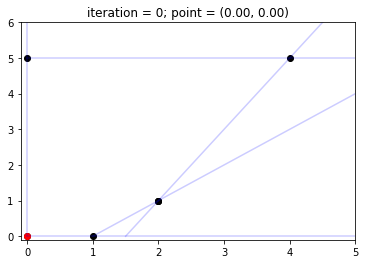

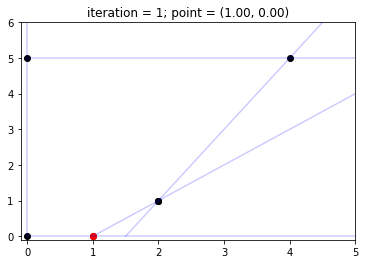

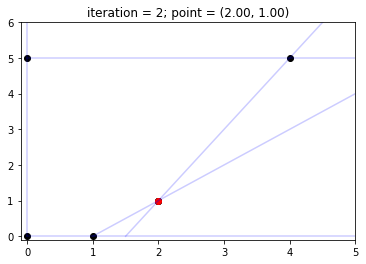

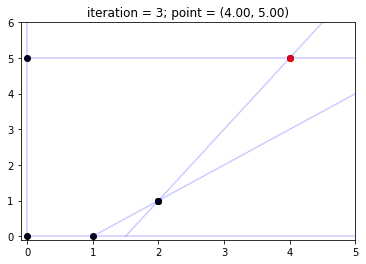

(31.0, array([ 4.,  5.]), 3)

In [23]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
simplex(2, A, b, c, draw=True)

In [24]:
A = np.array([[1, -1], [2, -1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
start_point = np.array([1, 1])
simplex(2, A, b, c, start_point=start_point)

[[ 1 -1]
 [ 2 -1]
 [ 0  1]]
[1 2 4]
[-4 -3]
[[ 1 -1]
 [ 0 -1]
 [ 0  1]]
[ 1.  0.  4.]
[ 4. -7.]
[[1 0]
 [0 1]
 [0 0]]
[ 1.  0.  4.]
[-10.   7.]
[[0 0]
 [0 1]
 [1 0]]
[ 3.  4.  2.]
[ 5.  2.]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:41: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(31.0, array([ 4.,  5.]), 3)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:41: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[[1 1]
 [5 2]
 [0 1]]
[ 1.8  0.   4. ]
[-10  -3]
[[0 1]
 [1 2]
 [0 1]]
[ 1.8  0.   4. ]
[ 2.  1.]


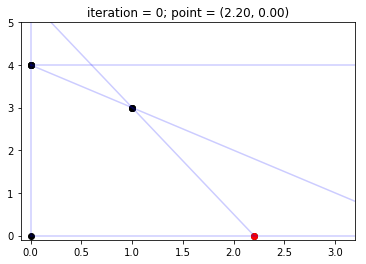

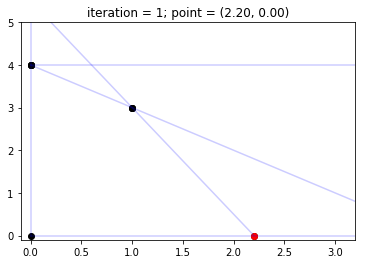

(22.0, array([ 2.2,  0. ]), 1)

In [25]:
A = np.array([[1, 1], [5, 2], [0, 1]])
b = np.array([4, 11, 4])
c = np.array([10, 3])
start_point = np.array([2.2, 0])
simplex(2, A, b, c, method='lexical', start_point=start_point, draw=True)

In [26]:
A = np.array([[1, 1], [5, 2], [0, 1]])
b = np.array([4, 11, 4])
c = np.array([10, 3])
simplex(2, A, b, c)

A = np.array([[1, 1], [5, 2], [0, 1]])
b = np.array([4, 11, 4])
c = np.array([10, 3])
start_point = np.array([2.2, 0])
simplex(2, A, b, c, start_point=start_point)

[[1 1]
 [5 2]
 [0 1]]
[ 4 11  4]
[-10  -3]
[[0 1]
 [1 2]
 [0 1]]
[ 1.8  2.2  4. ]
[ 2.  1.]
[[1 1]
 [5 2]
 [0 1]]
[ 1.8  0.   4. ]
[-10  -3]
[[0 1]
 [1 2]
 [0 1]]
[ 1.8  0.   4. ]
[ 2.  1.]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:41: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(22.0, array([ 2.2,  0. ]), 1)

In [27]:
A = np.array([[0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1], [1, 0, 0, 0]])
b = np.array([0, 0, 1])
c = np.array([10, -57, -9, -24])
start_point = np.array([1, 0, 1, 0])
simplex(4, A, b, c, method='lexical', start_point=None)

[[ 0.5 -5.5 -2.5  9. ]
 [ 0.5 -1.5 -0.5  1. ]
 [ 1.   0.   0.   0. ]]
[0 0 1]
[-10  57   9  24]
[[ 1.  -5.5 -2.5  9. ]
 [ 0.  -1.5 -0.5  1. ]
 [ 0.   0.   0.   0. ]]
[ 0.  0.  1.]
[  20.  -53.  -41.  204.]
[[ 1.   0.  -2.5  9. ]
 [ 0.   1.  -0.5  1. ]
 [ 0.   0.   0.   0. ]]
[ 0.  0.  1.]
[  6.75  13.25 -14.5   98.  ]
[[ 1.   0.   0.5  9. ]
 [ 0.   1.   0.5  1. ]
 [ 0.   0.   1.   0. ]]
[ 0.  0.  1.]
[-15.  93.  29. -18.]
[[-5.5  0.   0.5  9. ]
 [-1.5  1.   0.5  1. ]
 [ 0.   0.   1.   0. ]]
[ 0.  0.  1.]
[ 30.  18.  -1.  42.]
[[-5.5  0.   0.   9. ]
 [-1.5  1.   0.   1. ]
 [ 0.   0.   1.   0. ]]
[ 1.  2.  1.]
[ 30.  18.   1.  42.]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


(1.0, array([ 1.,  0.,  1.,  0.]), 5)

In [28]:
A = np.array([[0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1], [1, 0, 0, 0]])
b = np.array([0, 0, 1])
c = np.array([10, -57, -9, -24])
simplex(4, A, b, c)

A = np.array([[0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1], [1, 0, 0, 0]])
b = np.array([0, 0, 1])
c = np.array([10, -57, -9, -24])
start_point = np.array([1, 0, 1, 0])
simplex(4, A, b, c, start_point=start_point)

[[ 0.5 -5.5 -2.5  9. ]
 [ 0.5 -1.5 -0.5  1. ]
 [ 1.   0.   0.   0. ]]
[0 0 1]
[-10  57   9  24]
[[ 1.  -5.5 -2.5  9. ]
 [ 0.  -1.5 -0.5  1. ]
 [ 0.   0.   0.   0. ]]
[ 0.  0.  1.]
[  20.  -53.  -41.  204.]
[[ 1.   0.  -2.5  9. ]
 [ 0.   1.  -0.5  1. ]
 [ 0.   0.   0.   0. ]]
[ 0.  0.  1.]
[  6.75  13.25 -14.5   98.  ]
[[ 1.   0.   0.5  9. ]
 [ 0.   1.   0.5  1. ]
 [ 0.   0.   1.   0. ]]
[ 0.  0.  1.]
[-15.  93.  29. -18.]
[[-5.5  0.   0.5  9. ]
 [-1.5  1.   0.5  1. ]
 [ 0.   0.   1.   0. ]]
[ 0.  0.  1.]
[ 30.  18.  -1.  42.]
[[-5.5  0.   0.   9. ]
 [-1.5  1.   0.   1. ]
 [ 0.   0.   1.   0. ]]
[ 1.  2.  1.]
[ 30.  18.   1.  42.]
[[ 0.5 -5.5 -2.5  9. ]
 [ 0.5 -1.5 -0.5  1. ]
 [ 1.   0.   0.   0. ]]
[ 2.  0.  0.]
[-10  57   9  24]
[[ 0.  -5.5 -2.5  9. ]
 [ 1.  -1.5 -0.5  1. ]
 [ 0.   0.   0.   0. ]]
[ 2.  0.  0.]
[ 20.  27.  -1.  44.]
[[ 0.  -5.5  0.   9. ]
 [ 1.  -1.5  0.   1. ]
 [ 0.   0.   1.   0. ]]
[ 2.  0.  0.]
[ 18.  30.   1.  42.]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:41: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(1.0, array([ 1.,  0.,  1.,  0.]), 2)

In [29]:
A = np.array([[1, 1, 1, 1], [0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1]])
b = np.array([1, 0, 0])
c = np.array([-1, 7, 1, 2])
simplex(4, A, b, c)

A = np.array([[1, 1, 1, 1], [0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1]])
b = np.array([1, 0, 0])
c = np.array([-1, 7, 1, 2])
start_point = np.array([0, 1, 0, 0])
simplex(4, A, b, c, start_point=start_point)

[[ 1.   1.   1.   1. ]
 [ 0.5 -5.5 -2.5  9. ]
 [ 0.5 -1.5 -0.5  1. ]]
[1 0 0]
[ 1 -7 -1 -2]
[[ 1.   1.   1.   1. ]
 [ 0.5  0.  -2.5  9. ]
 [ 0.5  0.  -0.5  1. ]]
[ 1.   5.5  1.5]
[ 8.  7.  6.  5.]
[[ 1.   1.   1.   1. ]
 [ 0.5 -5.5 -2.5  9. ]
 [ 0.5 -1.5 -0.5  1. ]]
[ 0.   5.5  1.5]
[ 1 -7 -1 -2]
[[ 1.   1.   1.   1. ]
 [ 0.5  0.  -2.5  9. ]
 [ 0.5  0.  -0.5  1. ]]
[ 0.   5.5  1.5]
[ 8.  7.  6.  5.]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:41: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(7.0, array([ 0.,  1.,  0.,  0.]), 1)

In [30]:
A = np.array([[1, 1, 1, 1], [0.5, -5.5, -2.5, 9], [0.5, -1.5, -0.5, 1]])
b = np.array([1, 0, 0])
c = np.array([-1, 7, 1, 2])
start_point = np.array([0, 1, 0, 0])
simplex(4, A, b, c, method='lexical', start_point=None)

[[ 1.   1.   1.   1. ]
 [ 0.5 -5.5 -2.5  9. ]
 [ 0.5 -1.5 -0.5  1. ]]
[1 0 0]
[ 1 -7 -1 -2]
[[ 1.   1.   1.   1. ]
 [ 0.5  0.  -2.5  9. ]
 [ 0.5  0.  -0.5  1. ]]
[ 1.   5.5  1.5]
[ 8.  7.  6.  5.]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


(7.0, array([ 0.,  1.,  0.,  0.]), 1)

# ==========================================================
# Задача на МНК

In [31]:
''' Пусть физический закон описывается зависимостью 
    некоторого измеряемого значения y(x, a) 
    от времени и координаты x при параметрах a:
'''

def function(t, a): 
    return a[2] * sin(t) + a[1] * t + a[0]

In [32]:
''' Дан набор координат t размера m, значения распределены равномерно. 
    Пусть m = 200.
'''

m = 200
time = np.array([i * 10.0 / m for i in range(m)])

In [33]:
''' Для каждого момента времени t сгенерируйте соответствующее
    значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера:
'''

a = np.array([10, 100, 1000])

In [34]:
''' Выберем параметр b.
'''

b = 500

In [35]:
''' Результаты измерений отличаются от истинных значений 
    в силу действия случайной аддитивной помехи
    (случайность подчиняется нормальному закону распределения N(0, b))
'''

def get_y(a, b):
    y_real = np.array([function(i, a) for i in time])
    y_corr = y_real + np.random.normal(0, b, m)
    return y_real, y_corr

In [36]:
''' Сгенерируем значения: исходные и с помехами.
'''

y_real, y_corr = get_y(a, b)

In [37]:
''' По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    1) method = 0 -> сумма квадратов невязок будет минимальна;
    2) method = 1 -> сумма абсолютных значений невязок будет минимальна;
    3) method = 2 -> максимальное абсолютное значение невязки будет минимально.
'''

def get_params(y_corr, time, method=0):
    if method == 0:
        A = np.array([[1, t, sin(t)] for t in time])
        return np.linalg.inv(A.T @ A) @ A.T @ y_corr

## Задание 1

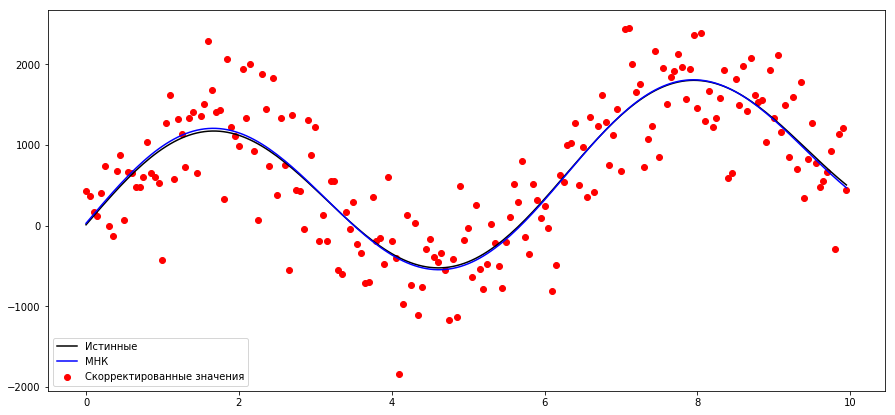

In [38]:
plt.figure(figsize=(15,7))

plt.scatter(time, y_corr, c='red', label='Скорректированные значения')

y = np.array([function(t, a) for t in time])
plt.plot(time, y, c='black', label='Истинные')

astar = get_params(y_corr, time)
y = np.array([function(t, astar) for t in time])
plt.plot(time, y, c='blue', label='МНК')

plt.legend()
plt.show()

In [39]:
print('Отличие истинных параметров и параметров, полученных с помощью МНК:')
print('\tИстинные:', a)
print('\tИз МНК:', np.round(astar, 2))

Отличие истинных параметров и параметров, полученных с помощью МНК:
	Истинные: [  10  100 1000]
	Из МНК: [   28.4     95.77  1022.  ]


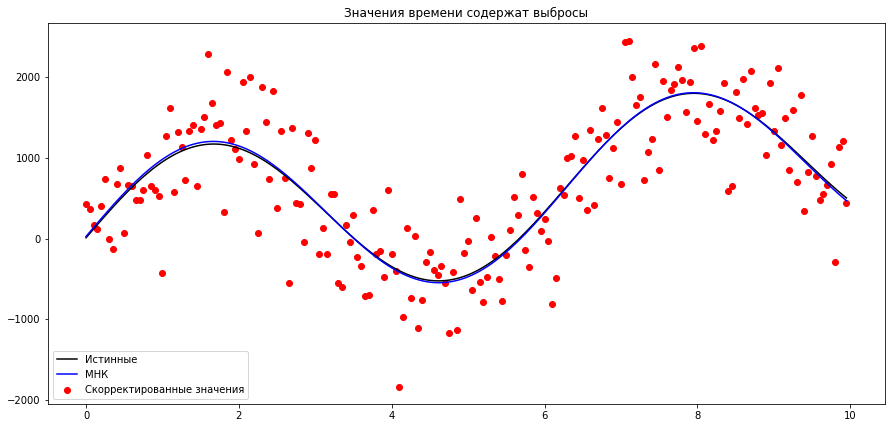

In [40]:
plt.figure(figsize=(15,7))

plt.scatter(time, y_corr, c='red', label='Скорректированные значения')

y = np.array([function(t, a) for t in time])
plt.plot(time, y, c='black', label='Истинные')

y_corrupt = y_corr.copy()
y_corrupt[0] -= 50
y_corrupt[-1] += 50
astar = get_params(y_corrupt, time)
y = np.array([function(t, astar) for t in time])
plt.plot(time, y, c='blue', label='МНК')

plt.title('Значения времени содержат выбросы')
plt.legend()
plt.show()

In [41]:
print('Отличие истинных параметров и параметров, полученных с помощью МНК\
      при наличии выбросов')
print('\tИстинные:', a)
print('\tИз МНК:', np.round(astar, 2))

Отличие истинных параметров и параметров, полученных с помощью МНК      при наличии выбросов
	Истинные: [  10  100 1000]
	Из МНК: [   26.97    96.06  1021.8 ]


## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?